In [8]:
%matplotlib inline
from nfl.fdb.const import *
from nfl.fdb import features as nfl_feat
from nfl import storage as nfl_db
from nfl.fdb import training as nfl_train
from nfl.fdb import aggregator as nfl_agg
from nfl.fdb import dataset as nfl_dataset
from nfl.sos import storage as sos_db
#year = 2013
YEARS = list(range(1995, 2015))

In [78]:
import imp
imp.reload(nfl_feat)
imp.reload(nfl_db)
imp.reload(nfl_train)
imp.reload(nfl_agg)

<module 'nfl.fdb.aggregator' from '/Users/eczech/repos/portfolio/functional/sports/python/nfl/fdb/aggregator.py'>

## Mongo Training Data Collection

In [2]:
# Initialize training data indexes (after truncation)
# db.dat_train_v1.drop()
# db.dat_train_v1.createIndex( { 'Attr:Player:Pos': 1} )
#nfl_db.add_index(DB, COLL_TRAIN_V1, [('Attr:Player:Pos', 1), ('Attr:Game:Year', 1)])

## Create Training Data

In [12]:
import functools
def get_game_matrix(games, player_stats, rosters, year, min_game_num=4):
    game_matrix = []    
    training_games = games[games['GameNumber'] >= min_game_num]
    n_games = len(training_games)
    i = 0; game_links = set()
    for _, game in training_games.iterrows():
        i += 1
        if i % 100 == 0:
            print('\tProcessing game {} of {}'.format(i, n_games))
        # Each game appears twice, once for each team involved, so duplicates
        # should not be reprocessed here 
        if game['OutcomeLink'] in game_links:
            continue
        game_links.add(game['OutcomeLink'])

        aggregator = nfl_agg.get_default_aggregator(year)
        parts = nfl_feat.get_game_context(game, games, player_stats, rosters, year, aggregator=aggregator)

        part = nfl_feat.get_matchup_matrix(game, *parts, aggregator=aggregator)
        #print(len(part))
        if len(part) > 0:
            game_matrix.append(part)
    if len(game_matrix) == 0:
        return None
    return functools.reduce(pd.DataFrame.append, game_matrix)

In [13]:
year = 2012
rosters =nfl_feat.get_rosters(year)
games = nfl_feat.get_games(year, remove_mirrored_records=False, query={'GameType': 'Regular Season'})
player_stats = nfl_feat.get_player_stats(games, year)

[Mongo] On extraction of document #10000
[Mongo] On extraction of document #20000
[Mongo] On extraction of document #30000
[Mongo] On extraction of document #10000


In [ ]:
gm = get_game_matrix(games, player_stats, rosters, year, min_game_num=3)
#gm.iloc[10][('Stat:Opp', 'QB:passing:Yds:1st')]
#gm.iloc[10]

In [ ]:
# dt = player_stats
# dt = dt[dt['PlayerName'] == 'John Skelton']
# dt = dt[dt['Metric'] == 'passing:Yds']
# dt = dt[dt['TeamId'] == 'arizona-cardinals']
# dt = dt[dt['Year'] == 2012]
# dt = dt[dt['GameNumber'] <= 8]
# dt.sort('Date')

In [ ]:
# dt = gm[gm[('Attr:Player', 'Pos')] == 'QB']
# dt = dt[dt[('Attr:Game', 'OutcomeLink')] == '/games/boxscore.html?gid=2012102103']
# dt[[c for c in dt if 'Attr:Player' in c[0] or c[1] == 'passing:Yds']]

In [ ]:
# from nfl.sos import storage as sos_db
# sos, sos_def = sos_db.get_sos_data([year])

In [63]:
dt = games.set_index(['Date', 'GameType'])
dt.index = dt.index.set_names(['Date', 'GT'])
dt.index.names[-1]

'GT'

In [99]:
import time


aggregator = nfl_agg.get_default_aggregator(year)
game_link = '/games/boxscore.html?gid=2012092311'
#game_link = '/games/boxscore.html?gid=2012112510'
game = games[games['OutcomeLink'] == game_link].iloc[0]
print(game)
tb = time.time()
vals = nfl_feat.get_game_context(game, games, player_stats, rosters, year, aggregator=aggregator)
print(time.time() - tb)
vals = nfl_feat.get_matchup_matrix(game, *vals, aggregator=aggregator)

dt = vals[vals[('Attr:Game', 'OutcomeLink')] == game_link]
dt = dt[dt[('Attr:Player', 'Player')] == 'Michael Vick']['Stat:Player']
#dt['Stat:Player'].T.dropna()
print(dt.T.dropna().to_dict())
#dt[[c for c in dt if 'QB:passing' in c[1]]].head().dropna(how='all', axis=1)

Attend                                                  60,436
Date                                       2012-09-23 00:00:00
GameType                                        Regular Season
Location          University of Phoenix Stadium (Glendale, AZ)
Opponent                                          Philadelphia
OpponentLink       /teams/nfl/philadelphia-eagles/results/2012
OutcomeLink                /games/boxscore.html?gid=2012092311
Result                                                  W 27-6
TeamId                                       arizona-cardinals
Year                                                      2012
GameNumber                                                   3
OpponentTeamId                             philadelphia-eagles
Name: 2, dtype: object
1.5406410694122314
{118: {'fumbles:Tot': {'n': 2, 'a': {'50': 0.015625, '10': 0.015625, '30': 0.015625, '20': 0.015625, '40': 0.015625, '90': 0.015625, '60': 0.015625, '70': 0.015625, '80': 0.015625}, 'v': 0.5}, 'defense:

In [74]:
dt[('Stat:Player', 'rushing:Yds')].dropna().head()

3                                                   1.8
8     {'n': 3, 'a': {'50': 0.791995125709, '10': 0.7...
17                                                  0.9
26    {'n': 6, 'a': {'50': 0.016072771856, '10': 0.0...
30    {'n': 6, 'a': {'50': 0.516735912857, '10': 0.4...
Name: (Stat:Player, rushing:Yds), dtype: object

In [15]:
from sklearn.grid_search import Parallel, delayed

def create_training_data(year):
    print('Creating training data for year {}'.format(year))
    rosters = nfl_feat.get_rosters(year)
    games = nfl_feat.get_games(year, query={'GameType': 'Regular Season'}, remove_mirrored_records=False)
    player_stats = nfl_feat.get_player_stats(games, year)
    game_matrix = get_game_matrix(games, player_stats, rosters, year, min_game_num=4)
    if game_matrix is None:
        print('Ignoring year {}'.format(year))
        return (year, False)
    game_matrix.columns = [c[0]+':'+c[1] for c in game_matrix]
    idx_cols = ['Attr:Game:Year', 'Attr:Game:TeamId', 'Attr:Game:Date', 'Attr:Player:PlayerLink']

    # Cleanup final result before storing it
    shape_before = game_matrix.shape

    # Drop any columns with all NA values
    game_matrix = game_matrix.dropna(axis=1, how='all')

    print('Saving game data with shape {} (shape before cleanup = {})'\
          .format(game_matrix.shape, shape_before))
    nfl_db.insert_data(DB, COLL_TRAIN_V1, game_matrix, idx_cols)
    return (year, True)
    
#res = Parallel(n_jobs=1, verbose=1)(delayed(create_training_data)(year) for year in YEARS)
#res = Parallel(n_jobs=4, verbose=1)(delayed(create_training_data)(year) for year in list(range(2004, 2013)))
res = Parallel(n_jobs=4, verbose=1)(delayed(create_training_data)(year) for year in list(range(2000, 2015)))

Creating training data for year 2000
Creating training data for year 2001
Creating training data for year 2002
Creating training data for year 2003
[Mongo] On extraction of document #10000[Mongo] On extraction of document #10000[Mongo] On extraction of document #10000[Mongo] On extraction of document #10000



[Mongo] On extraction of document #10000[Mongo] On extraction of document #10000[Mongo] On extraction of document #10000[Mongo] On extraction of document #10000





KeyboardInterrupt: 

## Modeling Tests

In [17]:
import imp
imp.reload(nfl_db)
imp.reload(nfl_feat)
imp.reload(nfl_train)

<module 'nfl.fdb.training' from '/Users/eczech/repos/portfolio/functional/sports/python/nfl/fdb/training.py'>

Fetch training data for a particular position:

In [62]:
cols = !cat nfl_train_cols.txt | grep 'DVOA'
#', '.join(cols)
#cols

In [20]:
imp.reload(nfl_dataset)

<module 'nfl.fdb.dataset' from '/Users/eczech/repos/portfolio/functional/sports/python/nfl/fdb/dataset.py'>

In [21]:
years = (2004, 2013)
#damping_factors = ['5', '10', '12', '15']
damping_factors = ['30']
min_game = 8
top_player_pct = .5
    
ds = nfl_dataset.DATASET_QB_YDS

X, y = ds.get_training_data(
    years, damping_factors, min_game=min_game, min_response=0, 
    non_na_cols=[ds.primary_predictor], top_player_pct=top_player_pct
)
X.info()

KeyError: 'Stat:Result:passing:Yds'

# RUN TSNE ***

In [647]:
X = X.fillna(0)

count     80.000000
mean      -7.867942
std       56.319052
min     -241.000000
25%      -21.200893
50%       -0.744643
75%       25.187202
max       80.944444
Name: diff, dtype: float64


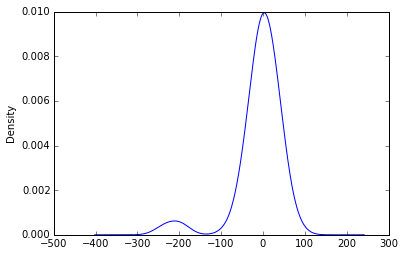

In [648]:
dt = X.copy()
dt[response] = y.values
dt = dt.reset_index().groupby(['Attr:Player:PlayerLink', 'Attr:Player:IsHome'])[response].mean()
dt = dt.unstack()
dt['diff'] = dt[1] - dt[0]
print(dt['diff'].describe())
dt['diff'].plot(kind='kde')
del dt

In [611]:
# d_export = X.copy()
# d_export[response] = y.values
# d_export.to_csv('/tmp/nfl_export.csv', index=False)

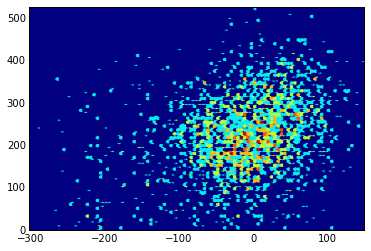

In [651]:
#plt.hexbin(X_res[primary_stat + ':Adj:90'], y_res, bins='log')
#plt.hexbin(X_res['Stat:Player:rushing:Yds:Diff'], y_res, bins='log')
#plt.hexbin(X_res['Stat:Team:QB:passing:Yds:Diff'], y_res, bins='log')
#plt.hexbin(X_res['Stat:Team:Pass DVOA:Diff'], y_res, bins='log')
#plt.hexbin(X_res['Stat:Team:RB:rushing:Yds:1st'], y_res, bins='log')
plt.hexbin(X['Stat:Player:passing:Yds:Diff'], y, bins='log')

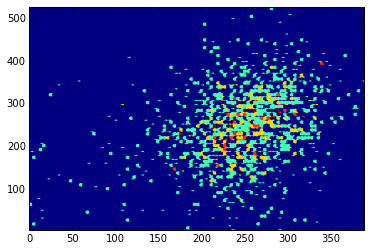

In [633]:
#plt.scatter(X['Stat:Diff:passing:Yds'], y, c=X['Stat:Player:ContribGF'])
#plt.scatter(X['Stat:Diff:rushing:Yds'], y, c=X['Stat:Player:ContribGF'])
plt.hexbin(X[primary_stat + ':Adj:12'], y, bins='log')

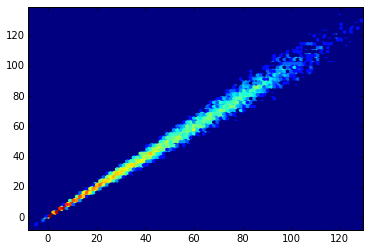

In [268]:
plt.hexbin(X[primary_stat + ':Adj:None'], X[primary_stat + ':Adj:90'], bins='log')

In [1198]:
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
GradientBoostingRegressor()

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [348]:
from nfl.fdb import benchmark as nfl_bench
imp.reload(nfl_bench)

<module 'nfl.fdb.benchmark' from '/Users/eczech/repos/portfolio/functional/sports/python/nfl/fdb/benchmark.py'>

In [653]:
from ml.model import models, common, importances
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from nfl.fdb.benchmark import BenchmarkRegressor
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import RandomizedLogisticRegression, ElasticNetCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile

gbr_grid = {
    'n_estimators': [50, 250],
    'learning_rate': [.01, .1, .001],
    'min_samples_leaf': [1, 3, 5],
    #'subsample': [.5, .2],
    'max_features': [None, .5, .1],
    'max_depth': [3, 5, 7]
}
etr_grid = {
    'n_estimators': [10, 250, 500],
    'min_samples_leaf': [1, 3, 5, 9],
    'max_depth': [1, 5, 9]
}
svr_grid1 = { 'C': np.logspace(-10, -2, 5), 'degree': [1, 2, 3], 'kernel': ['linear'] }
svr_grid2 = { 'C': np.logspace(-10, -2, 5), 'gamma': [.01, .001, .0001], 'kernel': ['rbf']}
knn_grid = {'n_neighbors': [3,5,10,25,50], 'weights': ['uniform', 'distance']}

n_jobs = 1
cv = 3
gbr = Pipeline([
    ('feats', ExtraTreesRegressor()), 
    ('clf', GridSearchCV(GradientBoostingRegressor(), gbr_grid, cv=cv, n_jobs=n_jobs))
])
bench = nfl_bench.FeatureSubsetRegressor(
    GradientBoostingRegressor(n_estimators=250, learning_rate=.01), 
    [ds.get_primary_predictor(), 'Stat:Player:passing:Att']
)
clfs = {
    #'gbr': gbr,
    'gbr': RandomizedSearchCV(GradientBoostingRegressor(), gbr_grid, n_iter=25, cv=cv, n_jobs=n_jobs),
    #'gbr': GridSearchCV(GradientBoostingRegressor(), gbr_grid, cv=cv, n_jobs=n_jobs),
    'etr': RandomizedSearchCV(ExtraTreesRegressor(), etr_grid, n_iter=25, cv=cv, n_jobs=n_jobs),
    #'knn': RandomizedSearchCV(KNeighborsRegressor(), knn_grid, n_iter=10, cv=cv, n_jobs=n_jobs),
    #'svr_linear': RandomizedSearchCV(SVR(), svr_grid1, n_iter=10, cv=cv, n_jobs=n_jobs),
    #'svr_rbf': RandomizedSearchCV(SVR(), svr_grid2, n_iter=10, cv=cv, n_jobs=n_jobs),
    #'lasso': Pipeline([('scale', StandardScaler()), ('clf', LassoCV(cv=cv, n_jobs=n_jobs, max_iter=10000))]),
    #'enet': ElasticNetCV(cv=cv, n_jobs=n_jobs, max_iter=10000),
    'bench_feat': bench,
    'benchmark0': BenchmarkRegressor(ds.get_primary_predictor())
#     'benchmark5': BenchmarkRegressor(ds.primary_predictor + ':Adj:5'),
#     'benchmark10': BenchmarkRegressor(ds.primary_predictor + ':Adj:10'),
#     'benchmark12': BenchmarkRegressor(ds.primary_predictor + ':Adj:12'),
#     'benchmark15': BenchmarkRegressor(ds.primary_predictor + ':Adj:15'),
#     'benchmark20': BenchmarkRegressor(ds.primary_predictor + ':Adj:20'),
#     'benchmark30': BenchmarkRegressor(ds.primary_predictor + ':Adj:30')
}
res = models.run_regressors(
    X, y, clfs, KFold(len(y_res), 8), keep_X=False, 
    par_n_jobs=-1, par_verbose=1,
    log_file='/tmp/nfl_cv.log')

Beginning cross validation (see /tmp/nfl_cv.log for progress updates)


[Parallel(n_jobs=-1)]: Done   1 out of   8 | elapsed:  3.5min remaining: 24.4min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.5min finished
INFO:ml.model.log:Running model ExtraTreesRegressor on fold 1
INFO:ml.model.log:Running model ExtraTreesRegressor on fold 2
INFO:ml.model.log:Running model ExtraTreesRegressor on fold 3
INFO:ml.model.log:Running model ExtraTreesRegressor on fold 4
INFO:ml.model.log:Running model ExtraTreesRegressor on fold 5
INFO:ml.model.log:Running model ExtraTreesRegressor on fold 6
INFO:ml.model.log:Running model ExtraTreesRegressor on fold 7
INFO:ml.model.log:Running model ExtraTreesRegressor on fold 8
INFO:ml.model.log:Running model FeatureSubsetRegressor on fold 1
INFO:ml.model.log:Running model FeatureSubsetRegressor on fold 2
INFO:ml.model.log:Running model FeatureSubsetRegressor on fold 3
INFO:ml.model.log:Running model FeatureSubsetRegressor on fold 4
INFO:ml.model.log:Running model FeatureSubsetRegressor on fold 5
INFO:ml.model.log:Running m

In [626]:
from ml.model import summaries as ml_precis
imp.reload(ml_precis)

<module 'ml.model.summaries' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/model/summaries.py'>

In [654]:
ml_precis.summarize_grid_parameters(res)

model_name  variable                
etr         max_depth         5.00      7
                              9.00      1
            min_samples_leaf  9.00      5
                              3.00      2
                              1.00      1
            n_estimators      250.00    6
                              500.00    2
gbr         learning_rate     0.01      8
            max_depth         7.00      6
                              3.00      2
            max_features      0.10      8
            min_samples_leaf  5.00      4
                              3.00      2
                              1.00      2
            n_estimators      250.00    8
dtype: int64

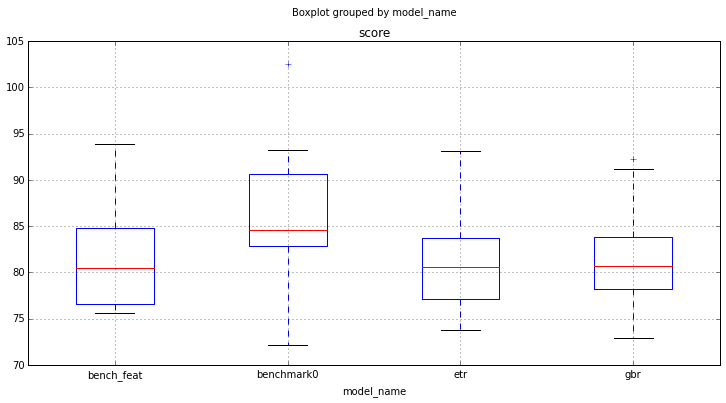

In [655]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
score_func = lambda clf, y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
#score_func = lambda clf, y_true, y_pred: mean_absolute_error(y_true, y_pred)
ml_precis.plot_model_scores(res, score_func=score_func)

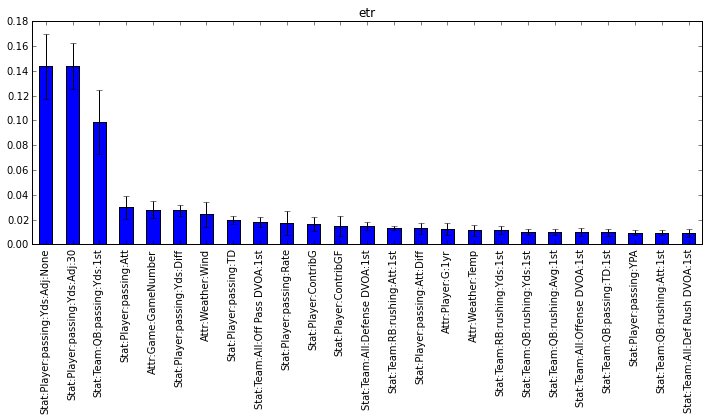

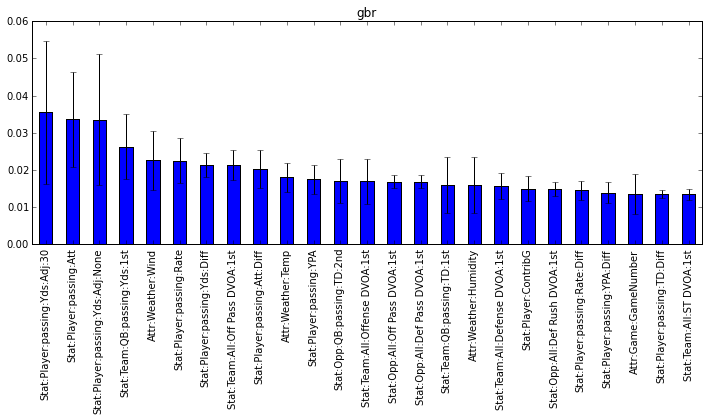

In [656]:
ml_precis.plot_feature_importance(res)

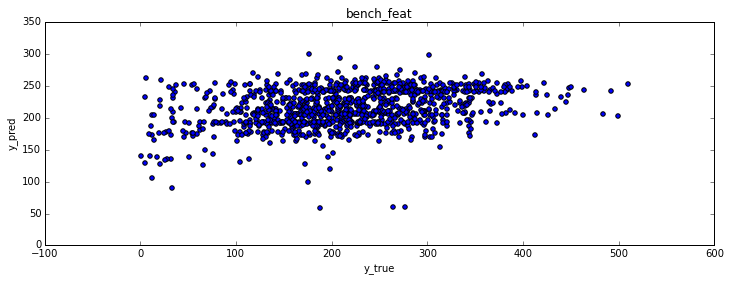

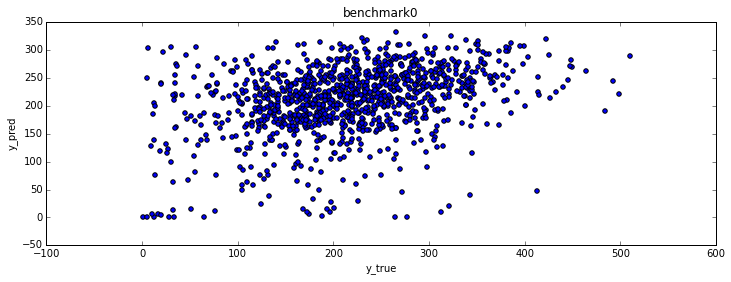

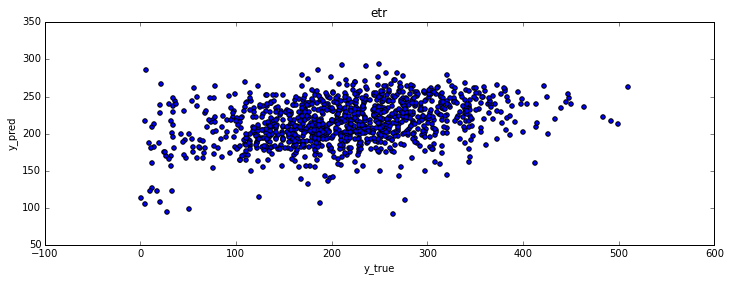

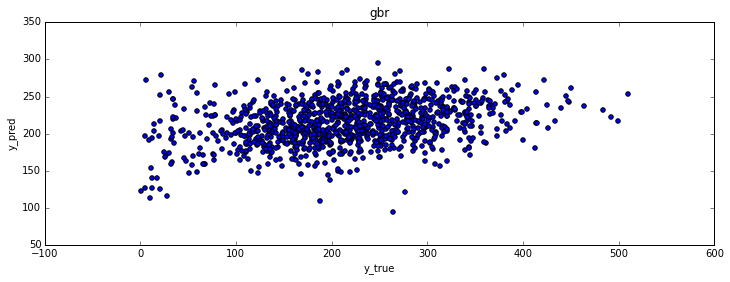

In [657]:
ml_precis.plot_predictions(res)

In [658]:
X_ho, y_ho = ds.get_training_data(
    (2014, 2014), damping_factors, min_game=min_game, min_response=0, 
    non_na_cols=[ds.primary_predictor], top_player_pct=top_player_pct
)
X_ho = X_ho.fillna(0)
X_ho.info()

KeyError: 'Stat:Result:passing:Yds'

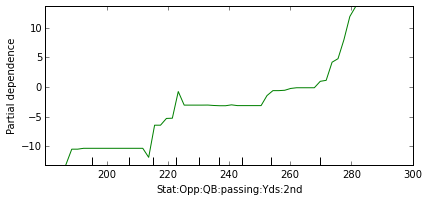

In [122]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
names = X.columns.tolist()

clf = GradientBoostingRegressor(n_estimators=500, max_depth=3, min_samples_leaf=7,
                                learning_rate=0.01, loss='huber', random_state=1)
clf.fit(X_train, y_train)
features = ['Stat:Opp:QB:passing:Yds:2nd']
fig, axs = plot_partial_dependence(clf, X_train, features, feature_names=names,
                                   n_jobs=3, grid_resolution=50)


## Scratch

In [110]:
def is_number(x):
    try:
        float(x)
        return False
    except:
        return True
mask = player_stats['Value'].apply(is_number)
player_stats[mask]['Value'].unique()

array(['2t', '66t', '22t', '23t', '20t', '68t', '38t', '37t', '71t', '89t',
       '8t', '25t', '24t', '74t', '21t', '44t', '19t', '100t', '32t',
       '45t', '41t', '48t', '29t', '43t', '54t', '60t', '94t', '49t',
       '52t', '59t', '26t', '75t', '69t', '17t', '40t', '18t', '58t',
       '98t', '10t', '82t', '79t', '85t', '0/0', '1/1', '2/2', '4/4', '--',
       '0/1', '1/2', '3/3', '0/2', '47,47B', '40B', '2/3', '4/5', '28B',
       '50,25', '2/4', '37,43', '3/4', '5/5', '7/7', '50,44', '6/6',
       '47,38', '35B', '66,47', '1/3', '37,49B', '34B', '57B', '35,50',
       '53,42', '0/3', '50,50,46', '42B', '1/4', '49,43,55', '49B', '48B',
       '8/8', '46,39B', '36B,26', '45,48', '37B', '34,32', '4/6', '32,48',
       '38B', '25B,59B', '53,71', '77t', '105t', '108t', '87t', '109t',
       '95t', '36t', '72t', '61t', '91t', '62t', '81t', '80t', '39t',
       '78t', '42t', '64t', '51t', '53t', '33t', '47t', '34t', '50t',
       '30t', '11t', '28t', '35t', '70t', '56t', '31t', '27t',